<a href="https://colab.research.google.com/github/budoorhza/PROJECT363/blob/main/verygood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import albumentations as A
from google.colab import drive
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

# نسخ الملف إلى مساحة العمل
!cp '/content/drive/MyDrive/363PROJECT/BrainTumorDataset.zip' /content/

# فك الضغط في مساحة العمل
import shutil
zip_path = '/content/BrainTumorDataset.zip'
extract_path = '/content/BrainTumorDataset'
shutil.unpack_archive(zip_path, extract_path)

In [5]:
print("Files in extracted folder:", os.listdir(extract_path))

Files in extracted folder: ['Training', 'Testing']


In [6]:
def load_data(main_dir, img_size=(128, 128)):
    images, masks = [], []
    classes = {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}  # تصنيفات الفئات
    for category in classes.keys():
        category_path = os.path.join(main_dir, category)
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)

            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, img_size)
            images.append(img)

            # إنشاء القناع
            mask = classes[category]
            masks.append(mask)

    images = np.array(images) / 255.0  # تطبيع الصور
    images = np.expand_dims(images, axis=-1)  # إضافة بُعد القناة
    masks = np.array(masks)  # تحويل الأقنعة إلى مصفوفة
    return images, masks

# مسارات المجلدات
training_dir = '/content/BrainTumorDataset/Training'
testing_dir = '/content/BrainTumorDataset/Testing'


# تحميل بيانات التدريب والاختبار
X_train, y_train = load_data(training_dir)
X_test, y_test = load_data(testing_dir)


# عرض الأشكال الأصلية للبيانات
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


# دالة لتحويل التصنيفات إلى أقنعة بكسلية
def create_pixel_masks(y, img_size=(128, 128), num_classes=4):
    masks = []
    for label in y:
        mask = np.zeros((img_size[0], img_size[1], num_classes))
        mask[..., int(label)] = 1  # تحويل الفئة إلى One-Hot
        masks.append(mask)
    return np.array(masks)

# إنشاء أقنعة بكسلية
y_train = create_pixel_masks(y_train, img_size=(128, 128), num_classes=4)
y_test = create_pixel_masks(y_test, img_size=(128, 128), num_classes=4)


X_train shape: (5712, 128, 128, 1)
y_train shape: (5712,)
X_test shape: (1311, 128, 128, 1)
y_test shape: (1311,)


In [7]:
# دالة لتوسيع البيانات باستخدام Albumentations
def augment_image(img):
    transform = A.Compose([
        A.RandomRotate90(),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    ])
    augmented = transform(image=img)['image']
    return augmented

# تطبيق التوسيع على بيانات التدريب
X_train_aug = np.array([augment_image(img.squeeze()) for img in X_train])
X_train_aug = np.expand_dims(X_train_aug, axis=-1)  # إعادة البعد المفقود
y_train_aug = y_train.copy()

In [8]:
# بناء نموذج U-Net مع تحسينات
def unet_model(input_size=(128, 128, 1), num_classes=4):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Dropout(0.2)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Dropout(0.2)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)

    # Decoder
    up4 = UpSampling2D(size=(2, 2))(conv3)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up4)

    up5 = UpSampling2D(size=(2, 2))(conv4)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up5)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(conv5)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', dice_coefficient, iou_metric])

    return model


In [9]:
# مقاييس التقييم: Dice و IoU
def dice_coefficient(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1e-7) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1e-7)

def iou_metric(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + 1e-7) / (union + 1e-7)

# بناء النموذج
model = unet_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 128, 128, 4)         │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 185,060 (722.89 KB)

 Trainable params: 185,060 (722.89 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
history = model.fit(
    X_train_aug, y_train_aug,
    validation_split=0.1,
    epochs=20,
    batch_size=16,
    callbacks=[lr_scheduler]
)



Epoch 1/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.5821 - dice_coefficient: 0.4814 - iou_metric: 0.3182 - loss: 0.9443 - val_accuracy: 0.3821 - val_dice_coefficient: 0.3102 - val_iou_metric: 0.1837 - val_loss: 1.3805 - learning_rate: 0.0010
Epoch 2/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.5768 - dice_coefficient: 0.4745 - iou_metric: 0.3122 - loss: 0.9502 - val_accuracy: 0.6145 - val_dice_coefficient: 0.4080 - val_iou_metric: 0.2564 - val_loss: 1.1040 - learning_rate: 0.0010
Epoch 3/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.5813 - dice_coefficient: 0.4831 - iou_metric: 0.3197 - loss: 0.9347 - val_accuracy: 0.4707 - val_dice_coefficient: 0.3395 - val_iou_metric: 0.2046 - val_loss: 1.3329 - learning_rate: 0.0010
Epoch 4/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.5862 - dice_coefficient: 0.4815 - iou_metric: 0.3182 - loss: 0.9384 - val_accuracy: 0.3788 - val_dice_coefficient: 0.3035 - val_iou_metric: 0.1790 - val_loss: 1.4

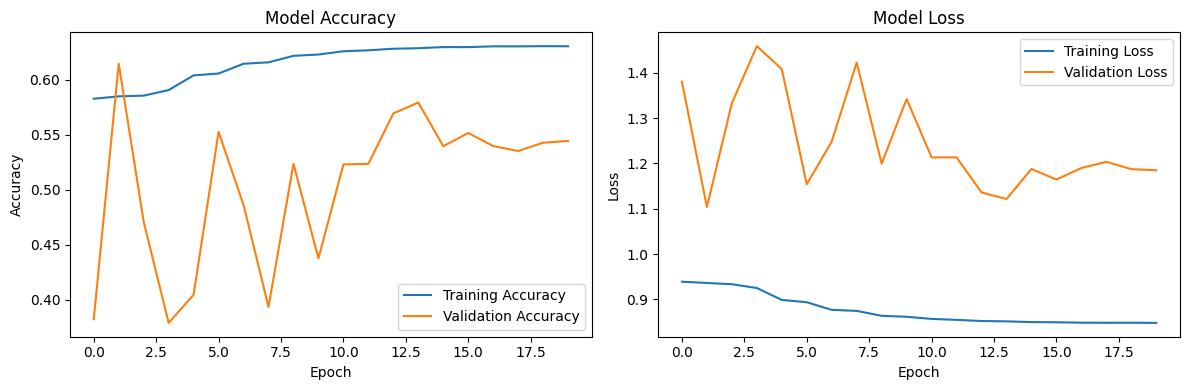

In [16]:
# رسم منحنيات التدريب
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


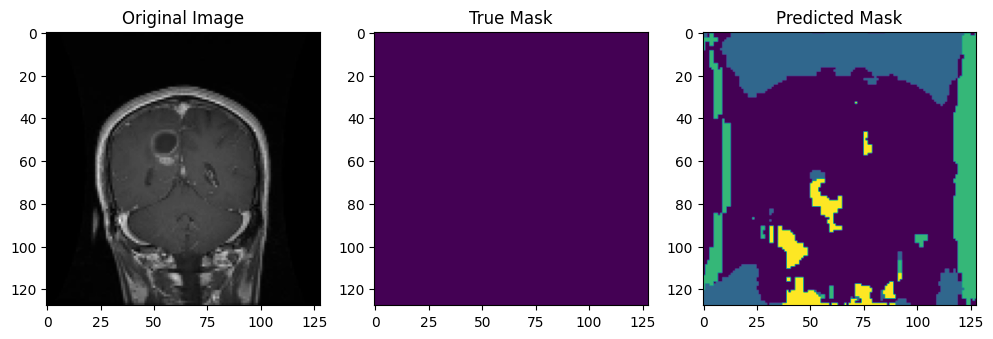

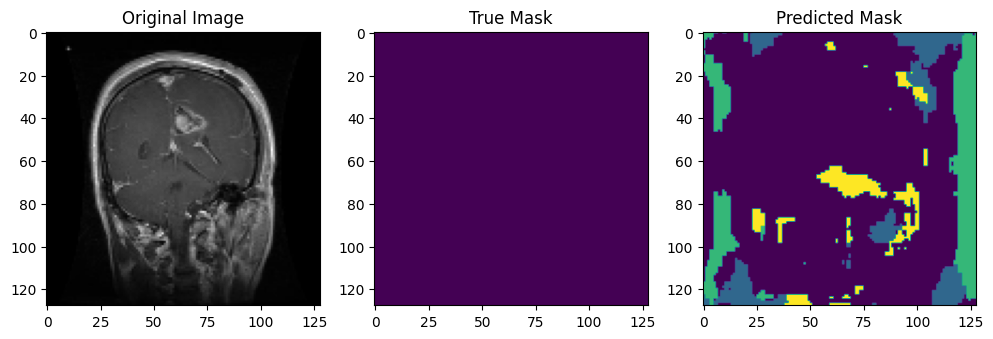

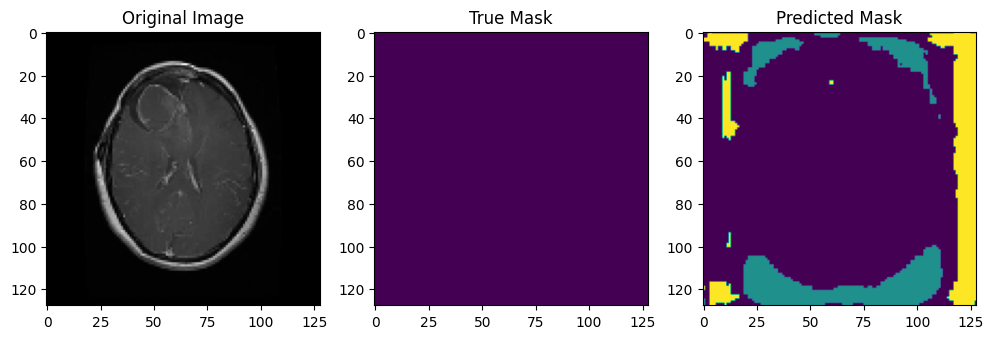

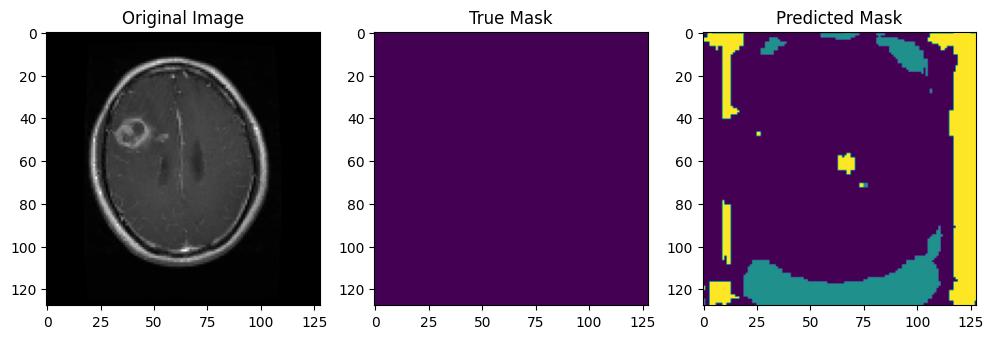

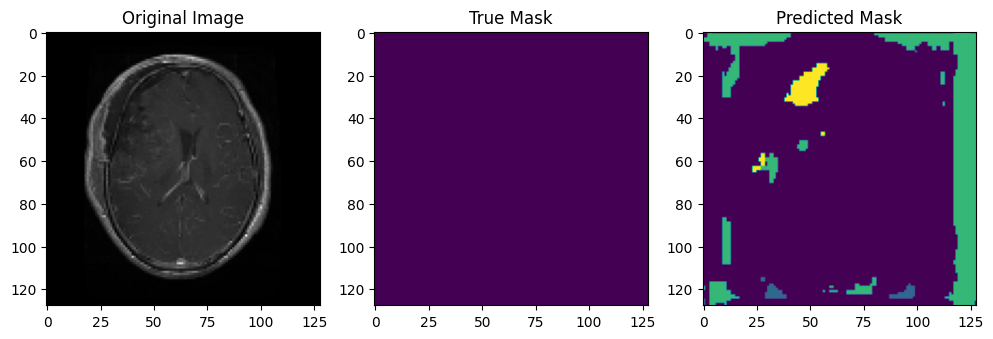

In [17]:
# التنبؤ وعرض النتائج
def predict_and_display(model, X_test, y_test, num_samples=5):
    preds = model.predict(X_test)
    for i in range(num_samples):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(X_test[i].squeeze(), cmap='gray')
        plt.title("Original Image")
        plt.subplot(1, 3, 2)
        plt.imshow(np.argmax(y_test[i], axis=-1), cmap='viridis')
        plt.title("True Mask")
        plt.subplot(1, 3, 3)
        plt.imshow(np.argmax(preds[i], axis=-1), cmap='viridis')
        plt.title("Predicted Mask")
        plt.show()

# اختبار النموذج
predict_and_display(model, X_test, y_test)